# Time series Cross Validation (CV) splits
> In this notebook some resources and code implementations to   
extend sciki-learn splitting methods for CV

[Using generators and yelds in Python](https://realpython.com/introduction-to-python-generators/?fbclid=IwAR3MsCOz5lqKm_oOF3F5kmr_y0W2xiBnnZleE9R23aMwtU3CkoOg6tz-wVA)   
[time-series cross validation walk-forward](https://medium.com/eatpredlove/time-series-cross-validation-a-walk-forward-approach-in-python-8534dd1db51a)   
[Cross validation strategies](https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/)   

Some useful books:   
<div style="display: inline-block;text-align: left" >
<a href="https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Bots-with-Python">
<img src="https://www.packtpub.com/media/catalog/product/cache/e4d64343b1bc593f1c5348fe05efa4a6/v/1/v12962_low.png" width="100px" style="display: block; margin:20px auto;" >
</a>

<a href="https://github.com/PacktPublishing/Hands-On-Machine-Learning-for-Algorithmic-Trading/tree/master/Chapter10">
<img src="https://www.packtpub.com/media/catalog/product/cache/e4d64343b1bc593f1c5348fe05efa4a6/b/1/b11166_new.png" width="100px"  style="display: block; margin:20px auto;">
</a>
<div>

## Import modules

In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    TimeSeriesSplit,
)
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
from IPython.core.debugger import set_trace

## CV plotting helper function

In [2]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):  #
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    ax.set(
        yticks=np.arange(n_splits),
        xticks=np.arange(len(indices), 1),
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits, -1],
    )  # , xlim=[0, 100])
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

## Simple X array to use as example

In [3]:
X = np.arange(1, 60, 3)
print(f"X: {X}")
n_sample = len(X)
print(f"\nNumber of samples:{n_sample}")

X: [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58]

Number of samples:20


# Blocking TimeSeries Split 
from "Hands-on Machine Learning for Algorithmic Trading Bots with Python"

In [ ]:
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits, waste):
        self.n_splits = n_splits
        self.waste = waste

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        waste = self.waste  # 32
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            print("Start: " + str(start) + " " + str(mid) + " stop: " + str(stop))
            yield indices[start:mid], indices[mid + waste : stop]

# Roll window
> A flexible roll window Cross-Validator useful for scenarios like:
* A fixed sized train window (rolling) 
* Everything that is not in training (even at previous time-steps)

In [ ]:
class RollWindow:
    """ Rolling Window cross-validator
    
        Provides train/test indices to split data samples
        that are observed at fixed time intervals, in train/test sets.
        In each split, test indices must be higher than before, 
        and thus shuffling in cross validator is inappropriate.

        Parameters
        ----------
        train_size : int, required
            Length of training set.

        shift_step : int, required
            Number of step to shift training window at each fold.
            If equal to training_size the resulting test sets
            do not overlap with training, if greater 
            
        horizon: int, optional
            Length of test set(forecasting horizon), If not provided
            all data till end of dataset is available as test.
        
        Return
        -------
        <genarator object> providing tuples of (Train, Test) indexes
        
    """

    def __init__(self, train_size, shift_step, horizon=None):
        self.train_size = train_size
        self.shift_step = shift_step
        self.horizon = horizon if not horizon is None else 0

    def split(self, X, y=None, groups=None):
        # define number of sample
        n_samples = len(X)
        # create an array of indexes
        indices = np.arange(n_samples)

        # defint initial start and end for training
        startTrain = 0
        endTrain = self.train_size

        # set iteration condition i.e. iterate while
        # trainig window + horizon does not reach the end
        # of indexes array
        while (indices[-1] - (endTrain + self.horizon)) >= 0:
            startTest = endTrain
            endTest = startTest + self.horizon
            if self.horizon > 0:
                indTest = np.hstack([indices[0:startTrain], indices[startTest:endTest]])
            else:
                # if self.horizon == 0 (not provided) test see extend till the end
                indTest = np.hstack([indices[0:startTrain], indices[startTest:]])
            # define training indexes
            indTrain = indices[startTrain:endTrain]
            # yield tuple of training and test indexes
            yield indTrain, indTest
            # update train indexes for next iteration
            startTrain = startTrain + self.shift_step
            endTrain = startTrain + self.train_size


train_size, period, horizon = 4, 4, None
rw = RollWindow(train_size=train_size, shift_step=period, horizon=horizon)
print(f"\nTrain size:{train_size}, Period:{period}, Horizon:{horizon}\n\n")
for i, (tr, tt) in enumerate(rw.split(X)):
    # print(f"Iteration: {i} -- [{tr[0]}, {tr[-1]}], [{tt[0]}, {tt[-1]}]")
    print(f"Xtrain: {X[tr]}, Xtest: {X[tt]}")
n_splits = sum(1 for _ in rw.split(X))

fig, ax = plt.subplots()
_ = plot_cv_indices(rw, X, None, ax, n_splits)
# ax.set_title('')

# Rollwindow Timeseries

In [108]:
class TimeSeriesRollWindowOLD:
    """ Time Series Rolling Window cross-validator
    
        Provides train/test indices to split data samples
        that are observed at fixed time intervals, in train/test sets.
        In each split, test indices must be higher than before, 
        and thus shuffling in cross validator is inappropriate.

        Parameters
        ----------
        train_size : int, required
            Length of training set.

        shift_step : int, required
            Number of step to shift training window at each fold.
            If equal to training_size the resulting test sets
            do not overlap with training, if greater 
            
        horizon: int, required
            Length of test set(forecasting horizon)
        
        Return
        -------
        <genarator object> providing tuples of (Train, Test) indexes
        
    """

    def __init__(self, train_size, shift_step, horizon):
        self.train_size = train_size
        self.shift_step = shift_step
        self.horizon = horizon
        self.n_splits = None

    def get_n_splits(self, X, y=None, groups=None):

        divider = (
            self.train_size
            if self.train_size >= self.shift_step
            else self.shift_step - self.train_size
        )
        # set_trace()
        if self.train_size != self.shift_step:
            diff = self.train_size - self.shift_step
        else:
            diff = self.train_size
        # sub = self.horizon if self.horizon >= self.shift_step else self.shift_step
        # self.n_splits = ((len(X) - sub) // divider) + diff
        available = len(X) - (self.train_size)
        den = diff + self.horizon
        print(f"avail:{available}, den:{den}, diff:{diff}")
        self.n_splits = 1 + (available // diff)
        print(f"Inner count:{self.n_splits}")
        return self.n_splits

    def split(self, X, y=None, groups=None):
        # define number of sample
        n_samples = len(X)
        # create an array of indexes
        indices = np.arange(n_samples)

        # defint initial start and end for training
        startTrain = 0
        startTest = 0
        endTrain = self.train_size
        endTest = 0

        # set iteration condition i.e. iterate while
        # trainig window + horizon does not reach the end
        # of indexes array
        # set_trace()
        while (indices[-1] - endTest) >= 0:  # (endTrain + self.horizon)
            startTest = endTrain
            endTest = startTest + self.horizon
            # define indexes for test set
            indTest = indices[startTest:endTest]
            # define training indexes
            indTrain = indices[startTrain:endTrain]
            # yield tuple of training and test indexes
            yield indTrain, indTest
            # update train indexes for next iteration
            startTrain = startTrain + self.shift_step
            endTrain = startTrain + self.train_size
            # check condition before next iteration
            if (indices[-1] - (endTrain + self.horizon)) < 0:
                break

In [152]:
class TimeSeriesRollWindow:
    """ Time Series Rolling Window cross-validator
    
        Provides train/test indices to split data samples
        that are observed at fixed time intervals, in train/test sets.
        In each split, test indices must be higher than before, 
        and thus shuffling in cross validator is inappropriate.

        Parameters
        ----------
        train_size : int, required
            Length of training set.

        shift_step : int, required
            Number of step to shift training window at each fold.
            If equal to training_size the resulting test sets
            do not overlap with training, if greater 
            
        horizon: int, required
            Length of test set(forecasting horizon)
        
        Return
        -------
        <genarator object> providing tuples of (Train, Test) indexes
        
    """

    def __init__(self, train_size, shift_step, horizon):
        self.train_size = train_size
        self.shift_step = shift_step
        self.horizon = horizon
        self.n_splits = None

    def get_n_splits(self, X, y=None, groups=None):
        n_samples=len(X)
        a = np.arange(n_samples)
        b = np.ones(self.train_size + self.horizon)
        shift_b = np.ones(self.shift_step)
        nsplit = 0
        while len(b) < len(a):
            b = np.append(b, shift_b)
            nsplit += 1
        self.n_splits = nsplit

        if self.n_splits > n_samples:
            raise ValueError(
                (
                    "Cannot have number of splits/folds ={0} greater"
                    " than the number of samples: {1}."
                ).format(self.n_splits, n_samples)
            )
        return self.n_splits

    def split(self, X, y=None, groups=None):
        # define number of sample
        n_samples = len(X)
        # create an array of indexes
        indices = np.arange(n_samples)

        # defint initial start and end for training
        startTrain = 0
        startTest = 0
        endTrain = self.train_size
        endTest = 0

        # set iteration condition i.e. iterate while
        # trainig window + horizon does not reach the end
        # of indexes array
        # set_trace()
        while (indices[-1] - endTest) >= 0:  # (endTrain + self.horizon)
            startTest = endTrain
            endTest = startTest + self.horizon
            # define indexes for test set
            indTest = indices[startTest:endTest]
            # define training indexes
            indTrain = indices[startTrain:endTrain]
            # yield tuple of training and test indexes
            yield indTrain, indTest
            # update train indexes for next iteration
            startTrain = startTrain + self.shift_step
            endTrain = startTrain + self.train_size
            # check condition before next iteration
            if (indices[-1] - (endTrain + self.horizon)) < 0:
                break


Train size:3, Period:4, Horizon:3


Xtrain: [1 4 7], Xtest: [10 13 16]
Xtrain: [13 16 19], Xtest: [22 25 28]
Xtrain: [25 28 31], Xtest: [34 37 40]
Xtrain: [37 40 43], Xtest: [46 49 52]
Number of splits: 4
Number splits returned by generator:4


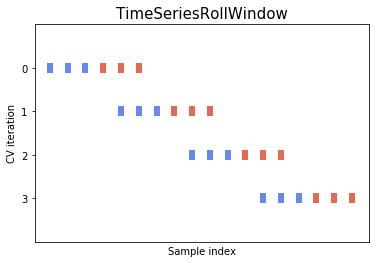

In [153]:
train_size_ts, step_ts, horizon_ts = 3, 4, 3
rw = TimeSeriesRollWindow(
    train_size=train_size_ts, shift_step=step_ts, horizon=horizon_ts
)
print(f"\nTrain size:{train_size_ts}, Period:{step_ts}, Horizon:{horizon_ts}\n\n")
for i, (tr, tt) in enumerate(rw.split(X)):
    print(f"Xtrain: {X[tr]}, Xtest: {X[tt]}")
    
print(f'Number of splits: {rw.get_n_splits(X)}')
# iterate generator to count number splits

n_splits = sum(1 for _ in rw.split(X))
print(f'Number splits returned by generator:{n_splits}')
fig, ax = plt.subplots()
_ = plot_cv_indices(rw, X, None, ax, n_splits)
# ax.set_title('')

In [127]:
a = np.arange(len(X))
b = np.ones(train_size_ts + horizon_ts)
shift_b = np.ones(step_ts)
iterr = 0
while len(b) < len(a):
    # print(b)
    b = np.append(b, shift_b)
    iterr += 1
print(iterr)

8


# TimeSeries Split implemented in Scikit-Learn

In [ ]:
ts = TimeSeriesSplit(n_splits=10)  # , max_train_size=4)
n_splits = sum(1 for _ in ts.split(X))
for i, (tr, tt) in enumerate(ts.split(X)):
    print(f"Iteration: {i} -- [{tr[0]}, {tr[-1]}], [{tt[0]}, {tt[-1]}]")

fig, ax = plt.subplots()
_ = plot_cv_indices(ts, X, None, ax, n_splits)

# Time Series Cross-Validation walk forward (Medium)
[Time Series Cross-validation — a walk forward approach in python](https://medium.com/eatpredlove/time-series-cross-validation-a-walk-forward-approach-in-python-8534dd1db51a)

In [ ]:
class expanding_window(object):
    """	
    Parameters 
    ----------
    
    Note that if you define a horizon that is too far, 
    then subsequently the split will ignore horizon length 
    such that there is validation data left. 
    This similar to Prof Rob hyndman's TsCv 
    
    
    initial: int
        initial train length 
    horizon: int 
        forecast horizon (forecast length). Default = 1
    period: int 
        length of train data to add each iteration 
    """

    def __init__(self, initial=1, horizon=1, period=1):
        self.initial = initial
        self.horizon = horizon
        self.period = period

    def split(self, data):
        """
        Parameters 
        ----------
        
        Data: Training data 
        
        Returns 
        -------
        train_index ,test_index: 
            index for train and valid set similar to sklearn model selection
        """
        self.data = data
        self.counter = 0  # for us to iterate and track later

        data_length = data.shape[0]  # rows
        data_index = list(np.arange(data_length))

        output_train = []
        output_test = []
        # append initial
        output_train.append(list(np.arange(self.initial)))
        progress = [
            x for x in data_index if x not in list(np.arange(self.initial))
        ]  # indexes left to append to train
        output_test.append(
            [x for x in data_index if x not in output_train[self.counter]][
                : self.horizon
            ]
        )
        # clip initial indexes from progress since that is what we are left

        while len(progress) != 0:
            temp = progress[: self.period]
            to_add = output_train[self.counter] + temp
            # update the train index
            output_train.append(to_add)
            # increment counter
            self.counter += 1
            # then we update the test index

            to_add_test = [
                x for x in data_index if x not in output_train[self.counter]
            ][: self.horizon]
            output_test.append(to_add_test)

            # update progress
            progress = [x for x in data_index if x not in output_train[self.counter]]

        # clip the last element of output_train and output_test
        output_train = output_train[:-1]
        output_test = output_test[:-1]

        # mimic sklearn output
        index_output = [(train, test) for train, test in zip(output_train, output_test)]

        return index_output


X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
X
y = np.array([1, 2, 3, 4, 5, 6])
tscv = expanding_window(initial=2, horizon=2, period=1)
for train_index, test_index in tscv.split(X):
    print(f"Train indexes:{train_index}, Test indexes:{test_index}")

# OneStep TimeSeries CV
From "Hands-On Machine Learning for Algorithmic Trading" (chapter 10)

In [ ]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, chunk_size):
        for i in range(0, len(l), chunk_size):
            yield l[i : i + chunk_size]

    def split(self, X, y=None, groups=None):
        unique_dates = (
            X.index.get_level_values("date")
            .unique()
            .sort_values(ascending=False)[: self.test_end]
        )

        dates = X.reset_index()[["date"]]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits